This notebook demonstrates inverse kinematics of manipulator using TTGO.

Copyright (c) 2008 Idiap Research Institute, http://www.idiap.ch/
    Written by Suhan Shetty <suhan.shetty@idiap.ch>,


In [1]:
import torch
import numpy as np
import sys
sys.path.append('../')

from planar_manipulator import PlanarManipulator
from cost_utils import PlanarManipulatorCost
from plot_utils import plot_chain
from utils import test_ttgo
import tt_utils
from ttgo import TTGO
import time
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4, suppress=True)

/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-dgsjxvy8 because the default path (/idiap/home/sshetty/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Define the robot paramters

In [3]:
n_joints = 3 # number of links
link_lengths = torch.tensor([1.4/n_joints]*n_joints).to(device)
max_theta = np.pi/1.1 # joint angle limits
min_theta = -1*max_theta
# define the robot
robot = PlanarManipulator(n_joints=n_joints,link_lengths=link_lengths,max_theta=max_theta,n_kp=5,
                          device=device)

In [4]:
link_lengths = torch.tensor([1.4/n_joints]*n_joints).to(device)
x_obst = [torch.tensor([0.5,0.5]),torch.tensor([-0.35,0.]),
          torch.tensor([-0.25,0.75]),torch.tensor([0,-0.75])]
x_obst = [x.to(device) for x in x_obst]

r_obst = [0.25,0.15,0.25,0.3]
margin=0.025 # margin for collision avoidance
w_goal= 0.5; w_obst= 0.5; # weights for each sub-cost
b_goal= 0.5; b_obst= 4 # nominal costs

robot = PlanarManipulator(n_joints=n_joints,link_lengths=link_lengths,max_theta=max_theta,n_kp=10,
                          device=device)
costPlanarManipulator = PlanarManipulatorCost(robot,x_obst=x_obst,r_obst=r_obst, margin=margin, 
                                              w_goal=w_goal, w_obst=w_obst,
                                              b_goal=b_goal, b_obst=b_obst, device=device)

Discretization of the domain

In [5]:
# Define the range of target poses of the end-effector
pose_max = torch.sum(link_lengths)
pose_min = -1*pose_max

# Discretize the domain
d0_x = 30
d0_theta = 30
domain_task=  [torch.linspace(pose_min,pose_max,d0_x).to(device)]*2 # position of ee
domain_decision = [torch.linspace(min_theta,max_theta,d0_theta).to(device)]*n_joints # joint angles
domain =  domain_task + domain_decision 


In [6]:

def cost(x):
    return costPlanarManipulator.cost_ik(x)[:,0]



### Fit TT-Model for the PMF

In [7]:
use_fusion = True # more efficient if True
# for target reaching

def cost_goal(x):
    d_goal = costPlanarManipulator.cost_goal(x)
    return d_goal

def pdf_goal(x):
    d_goal = cost_goal(x)#costPlanarManipulator.cost_ik(x)[:,1]
    return torch.exp(-(d_goal/0.5)**2) 

def cost_obst(q): 
    return costPlanarManipulator.cost_ik(q)[:,2]

def pdf_obst_q(q):
    kp_loc = robot.forward_kin(q)[0] # get position of key-points and the end-effector
    d_obst = costPlanarManipulator.dist_obst(kp_loc)
    return torch.exp(-(d_obst/4)**2) 

if use_fusion:
    print("Find tt_model of pdf_goal:")
    tt_goal = tt_utils.cross_approximate(fcn=pdf_goal,  domain=domain, 
                            rmax=100, nswp=20, eps=1e-3, verbose=True, 
                            kickrank=5, device=device)
    
    print(tt_goal.ranks_tt)



    print("Find tt_model of pdf_obst:")
    tt_obst_q = tt_utils.cross_approximate(fcn=pdf_obst_q,  domain=domain_decision, 
                            rmax=100, nswp=20, eps=1e-3, verbose=True, 
                            kickrank=5, device=device)
    print(tt_obst_q.ranks_tt)


    # make sure the dimensions of tt_obst matches with that of tt_model desired
    # i.e. pdf_obst(x_task,q) = pdf_obst_q(q)
    tt_obst = tt_utils.extend_model(tt_model=tt_obst_q,site=0,n_cores=2,d=[d0_x]*2).to(device)

    print("Take product: pdf(x_task,x_decision) = pdf_goal(x_task,x_decision)*pdf_obst(x_decision)")
    tt_model = tt_goal.to(device)*tt_obst.to(device)

    tt_model.round_tt(1e-3)
    

else: # compute the pdf directly using the cost function (less efficient) 
    def pdf(x):
        return torch.exp(-1*cost(x)**2)
    tt_model = tt_utils.cross_approximate(fcn=pdf,  domain=domain, 
                            rmax=200, nswp=20, eps=1e-3, verbose=True, 
                            kickrank=5, device=device)

print("Rank of TT-model: ", tt_model.ranks_tt)

Find tt_model of pdf_goal:
cross device is cuda
Cross-approximation over a 5D domain containing 2.43e+07 grid points:
iter: 0  | tt-error: 1.000e+00, test-error:9.937e-01 | time:   1.2871 | largest rank:   1
iter: 1  | tt-error: 5.526e+00, test-error:8.457e-01 | time:   1.3381 | largest rank:   6
iter: 2  | tt-error: 8.440e-01, test-error:7.287e-01 | time:   1.3938 | largest rank:  11
iter: 3  | tt-error: 8.501e-01, test-error:4.750e-01 | time:   1.4585 | largest rank:  16
iter: 4  | tt-error: 4.524e-01, test-error:2.680e-01 | time:   1.5432 | largest rank:  21
iter: 5  | tt-error: 2.111e-01, test-error:1.771e-01 | time:   1.6354 | largest rank:  26
iter: 6  | tt-error: 1.327e-01, test-error:1.142e-01 | time:   1.7377 | largest rank:  31
iter: 7  | tt-error: 9.266e-02, test-error:7.670e-02 | time:   1.8467 | largest rank:  36
iter: 8  | tt-error: 6.475e-02, test-error:4.781e-02 | time:   1.9583 | largest rank:  41
iter: 9  | tt-error: 3.952e-02, test-error:3.298e-02 | time:   2.0874 | 

In [8]:
# Refine the discretization and interpolate the model
scale_factor = 50
site_list = torch.arange(len(domain))#len(domain_task)+torch.arange(len(domain_decision))
domain_new = tt_utils.refine_domain(domain=domain, 
                                    site_list=site_list,
                                    scale_factor=scale_factor, device=device)
tt_model_new = tt_utils.refine_model(tt_model=tt_model, 
                                    site_list=site_list,
                                    scale_factor=scale_factor, device=device)

In [9]:
ttgo = TTGO(domain=domain_new,tt_model=tt_model_new.to(device), cost=cost, device=device)

### Test the model

In [47]:
# Generate test set (feasible target points)
ns = 1000
test_theta = torch.zeros(ns,n_joints).to(device)
for i in range(n_joints):
    unif = torch.distributions.uniform.Uniform(low=min_theta,high=max_theta)
    sample = torch.tensor([unif.sample() for i in range(ns)]).to(device)
    test_theta[:,i] = sample
    
_, _, test_x, test_orient = robot.forward_kin(test_theta)

test_set = torch.cat((test_x,test_theta),dim=-1)
cost_values = cost(test_set)
test_set = test_set[cost(test_set)<0.05]
ns = min(test_set.shape[0],50)
test_task = test_set[:ns,:len(domain_task)]


In [11]:
# # # Save the model
# file_name = 'planar_ik_.pickle'
# torch.save({
#     'tt_model':ttgo.tt_model,
#     'w': (w_goal,w_obst),
#     'b': (b_goal,b_obst),
#     'd0':(d0_x,d0_theta),
#     'margin': margin,
#     'domain': domain,
#     'test_task': test_task,
#     'x_obst':x_obst,
#     'r_obst':r_obst,
#     'n_joints':n_joints,
#     'link_lengths':link_lengths
#     }, file_name)


In [48]:
n_samples_tt = 50
alpha = 0.9
print("total-cost | dist-to-goal | num-of-collisions ")
_ = test_ttgo(ttgo=ttgo.clone(), cost= costPlanarManipulator.cost_ik, test_task=test_task, 
          n_samples_tt=n_samples_tt, deterministic=False, alpha=alpha, device=device, 
          test_rand=True, cut_total=0.05)


total-cost | dist-to-goal | num-of-collisions 
################################################################
################################################################
deterministic:False  |  alpha:0.9  |  n_samples_tt:50  |  n_samples_rand:50 | 
################################################################
################################################################
Cost TT (raw)           :  tensor([0.05, 0.05, 0.03], device='cuda:0')
Cost TT (optimized)     :  tensor([0.00, 0.00, 0.01], device='cuda:0')
Cost rand (raw)           :  tensor([0.24, 0.22, 0.14], device='cuda:0')
Cost rand (optimized)     :  tensor([0.02, 0.01, 0.02], device='cuda:0')
-------------------------------------
Performance, c_total <  0.05  (intersection)
-------------------------------------
Success-rate (tt vs rand) :  1.0 0.92
# iterations (tt vs rand) :  5.608695652173913 7.543478260869565
Cost-mean-tt-raw: tensor([0.05, 0.05, 0.03], device='cuda:0')
Cost-mean-tt-opt: tensor([0.00, 0.00, 0.

### Visualization

In [61]:
# choose a task-parameter (target position of end-effector)
s = np.random.choice(np.arange(ns))
x_task = test_task[s]

# Sample from TT-model
alpha=0.8
n_samples = 500
t1 = time.time()
# samples= ttgo.sample_random(n_samples=n_samples, x_task=x_task[None,:])
samples= ttgo.sample_tt(n_samples=n_samples, x_task=x_task[None,:], alpha=alpha, deterministic=False)
# Fine tune the approximation
best_estimate_tt = ttgo.choose_best_sample(samples)[0]
best_estimate_tt_opt = ttgo.optimize(best_estimate_tt)
t2 = time.time()


In [62]:
# For multiple solutions
k = 10
top_k_estimate_tt = ttgo.choose_top_k_sample(samples,k)[0]
top_k_estimate_tt_opt = 1*top_k_estimate_tt
for i in range(k):
    top_k_estimate_tt_opt[i,:], _ = ttgo.optimize(top_k_estimate_tt[i,:].view(1,-1))



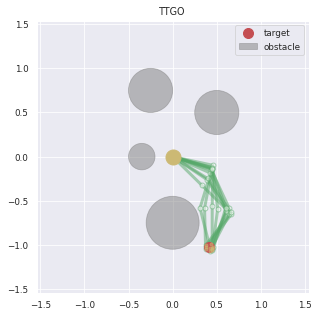

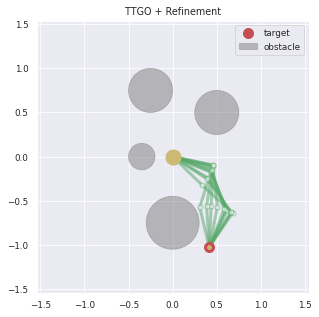

In [63]:

figsize=5    
    
_,joint_loc,_,_ = robot.forward_kin(top_k_estimate_tt[:,x_task.shape[-1]:])
joint_loc = joint_loc.cpu().numpy()
link = link_lengths.cpu().numpy()
x_obst_np = [x.cpu().numpy() for x in x_obst]
x_target = [x_task[:2].cpu().numpy()]

title="TTGO"
plt = plot_chain(joint_loc=joint_loc, link_lengths=link, x_obst=x_obst_np, r_obst=r_obst, 
           x_target=x_target, batch=True, skip_frame=1,figsize=figsize, title=title, 
           color_intensity=0.9, motion=False, alpha=0.5, contrast=0.3,lw=3)


_,joint_loc,_,_ = robot.forward_kin(top_k_estimate_tt_opt[:,x_task.shape[-1]:])
joint_loc = joint_loc.cpu().numpy()

title = "TTGO + Refinement"
plt = plot_chain(joint_loc=joint_loc, link_lengths=link, x_obst=x_obst_np, r_obst=r_obst, 
           x_target=x_target, batch=True, skip_frame=1, figsize=figsize, title=title, 
           color_intensity=0., motion=False, alpha=0.5, contrast=0., task='ik',lw=3)